In [1]:
# !pip install pyyaml==5.1

import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

fatal: destination path 'detectron2' already exists and is not an empty directory.


/tmp/ipykernel_4242/1082353035.py:3: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import sys, os, distutils.core


/bin/bash: line 1: python: command not found


In [21]:
import torch, detectron2

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch.cuda.is_available()
print(torch.version.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6
2.2.0+cu121


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg   
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, Metadata

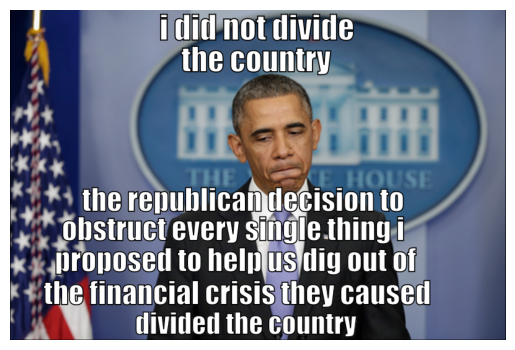

In [10]:
image_path = "./hateful_memes/img/01892.png"
# image_path = './TASK2/infilled_img/01892.png'

# Try to load the image
im = cv2.imread(image_path)

image_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# print(torch.cuda.memory_summary())

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()

In [5]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# passing the image to the predictor
outputs = predictor(im)

[02/19 03:37:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/home/pratyush/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([0], device='cuda:0')
Boxes(tensor([[349.6886, 118.5383, 505.3624, 298.6003]], device='cuda:0'))


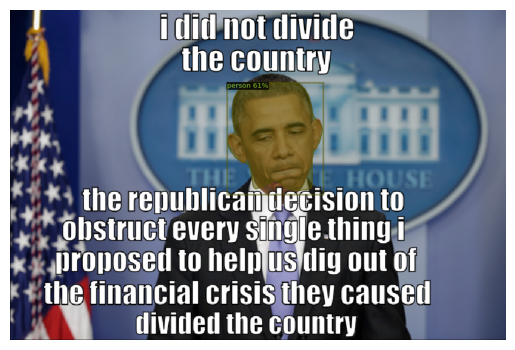

Detected class: person, Frequency: 1


In [11]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

image_rgb = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()

from collections import Counter

# Assuming outputs["instances"] contains the instance predictions
detected_classes = outputs["instances"].pred_classes.cpu().numpy()

# Count the occurrences of each class
class_counts = Counter(detected_classes)

# Print the classes along with their frequencies
for class_id, frequency in class_counts.items():
    class_name = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[class_id]
    print(f"Detected class: {class_name}, Frequency: {frequency}")

[02/19 03:37:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


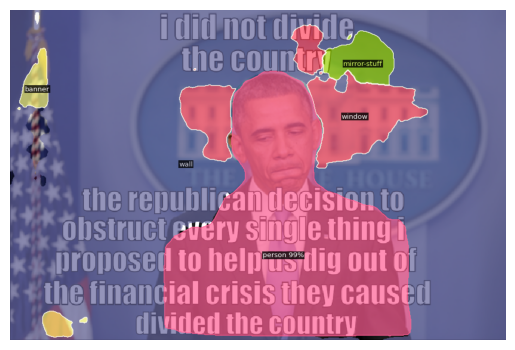

Unknown class ID: 0, Frequency: 1
Unknown class ID: 1, Frequency: 1
Unknown class ID: 14, Frequency: 1
Unknown class ID: 36, Frequency: 1
Unknown class ID: 52, Frequency: 1


In [12]:
# pantopic

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
# cv2_imshow(out.get_image()[:, :, ::-1])

image_rgb = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()

# print(segments_info)

class_ids = [info["category_id"] for info in segments_info]

# Count the occurrences of each class
class_counts = Counter(class_ids)

# Get the metadata catalog
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# thing_classes = metadata.thing_classes

# # Print the classes
# print(f"Thing Classes in the COCO Panoptic dataset: {thing_classes}")

# Print the classes along with their frequencies
# for class_id, frequency in class_counts.items():
#     class_name = metadata.thing_classes[class_id] if class_id in metadata.thing_classes else metadata.stuff_classes[class_id]
#     print(f"Detected class: {class_name}, Frequency: {frequency}")

for class_id, frequency in class_counts.items():
    if class_id in metadata.thing_classes:
        class_name = metadata.thing_classes[class_id]
        print(f"Detected 'thing' class: {class_name}, Frequency: {frequency}")
    elif class_id in metadata.stuff_classes:
        class_name = metadata.stuff_classes[class_id]
        print(f"Detected 'stuff' class: {class_name}, Frequency: {frequency}")
    else:
        print(f"Unknown class ID: {class_id}, Frequency: {frequency}")

In [18]:
import os
import cv2
import pandas as pd
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from collections import Counter
import jsonlines

# Specify the path to the folder containing images
# img_folder = "./hateful_memes/"
img_folder = './TASK2/infilled_img/'

# Get a list of 1000 image files from the folder
# image_files = sorted(os.listdir(img_folder))[:10]

jsonl_file_path = "./hateful_memes/train.jsonl" # change here for different image.jons

# Initialize an empty list to store labels
labels = []
image_files = []

# Read the jsonl file and extract labels
with jsonlines.open(jsonl_file_path) as reader:
    for entry in reader:
        # labels.append(entry["label"])
        image_files.append(entry['img'])

print(image_files)


# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=["Image", "Detected_Classes", "Class_Frequencies"])

['img/42953.png', 'img/23058.png', 'img/13894.png', 'img/37408.png', 'img/82403.png', 'img/16952.png', 'img/76932.png', 'img/70914.png', 'img/02973.png', 'img/58306.png', 'img/79351.png', 'img/34096.png', 'img/25489.png', 'img/19324.png', 'img/79346.png', 'img/13426.png', 'img/97628.png', 'img/14238.png', 'img/28936.png', 'img/59784.png', 'img/02146.png', 'img/70146.png', 'img/28061.png', 'img/97180.png', 'img/49752.png', 'img/25610.png', 'img/15872.png', 'img/72640.png', 'img/64318.png', 'img/17956.png', 'img/93547.png', 'img/10743.png', 'img/37091.png', 'img/25719.png', 'img/76825.png', 'img/72598.png', 'img/43078.png', 'img/51846.png', 'img/01569.png', 'img/95812.png', 'img/06418.png', 'img/53976.png', 'img/70193.png', 'img/60427.png', 'img/78395.png', 'img/04876.png', 'img/92075.png', 'img/86354.png', 'img/74386.png', 'img/59613.png', 'img/10263.png', 'img/48279.png', 'img/52610.png', 'img/58371.png', 'img/27401.png', 'img/89574.png', 'img/25473.png', 'img/47913.png', 'img/08295.pn

In [20]:
results_list = []

# Process each image
for i,image_file in enumerate(image_files):              # change the 0 here
    # Construct the full path to the image
    # image_path = os.path.join(img_folder, image_file)
    image_path = os.path.join(img_folder, image_file[4:])

    # Try to load the image
    im = cv2.imread(image_path)

    # Make predictions
    outputs = predictor(im)

    # Extract detected classes
    detected_classes = outputs["instances"].pred_classes.cpu().numpy()

    name_list = []

    # Count class occurrences
    class_counts = Counter(detected_classes)

    for class_id, frequency in class_counts.items():
        class_name = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[class_id]
        # print(f"Detected class: {class_name}, Frequency: {frequency}")
        name_list.append(class_name)
    print(i+1)

    new_dict = {}

    for i in class_counts.keys():
        new_dict[MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[i]]=class_counts[i]

    # Append results to list
    results_list.append({
        "Image": image_file,
        "Detected_Classes": name_list,
        "Class_Frequencies": new_dict
    })

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)

# Save results to CSV
results_df.to_csv("image_classes_infilled.csv", index=False) # to save the results here



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
